In [1]:
#本脚本主要用于使用图片检索其它模态
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import math
import os
 
import tensorflow as tf
from im2txt import configuration
from im2txt import inference_wrapper
from im2txt.inference_utils import caption_generator
from im2txt.inference_utils import vocabulary
import matplotlib.pyplot as plt
from PIL import Image

import pandas as pd

from sentence_transformers import SentenceTransformer
import scipy.spatial

import matplotlib.image as mpimg # mpimg 用于读取图片
import numpy as np
import cv2 as cv

import sys 

o_path = os.path.dirname(os.getcwd()) # 返回上级目录
sys.path.append(o_path) # 添加自己指定的搜索路径
from rank_bm25_K.rank_bm25 import BM25Plus

from nltk.corpus import stopwords as pw
import re

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [2]:
# 训练好的模型存放路径
checkpoint_path = "./model/model.ckpt-3000000"
# 词汇表
vocab_file = "./im2txt/data/word_counts.txt"
# 查询图片路径
input_files = os.path.join(os.path.dirname(os.getcwd()),"images_q/")

In [3]:
# 储存图片的内容
df = pd.DataFrame(columns=["Image_Path","Image_Content"])

#print(df)

In [4]:
# 载入训练好的模型
g = tf.Graph()
with g.as_default():
    model = inference_wrapper.InferenceWrapper()
    restore_fn = model.build_graph_from_config(configuration.ModelConfig(), checkpoint_path)

# 载入词表
vocab = vocabulary.Vocabulary(vocab_file)


INFO:tensorflow:Building model.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.TFRecordDataset`.





Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use `tf.cast` instead.



Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor



INFO:tensorflow:Initializing vocabulary from file: ./im2txt/data/word_counts.txt

INFO:tensorflow:Created vocabulary with 11520 words


INFO:tensorflow:Loading model from checkpoint: ./model/model.ckpt-3000000
INFO:tensorflow:Restoring parameters from ./model/model.ckpt-3000000
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-3000000
E:\大学相关\大学相关（大四春）\major\workspace\images_q/1.jpg
Instructions for updating:
Use tf.gfile.GFile.
  0) a dog laying on the grass with a soccer ball . (p=0.000563)
  1) a dog laying on the grass with a soccer ball in its mouth . (p=0.000241)
  2) a dog laying on the ground with a soccer ball in its mouth . (p=0.000103)


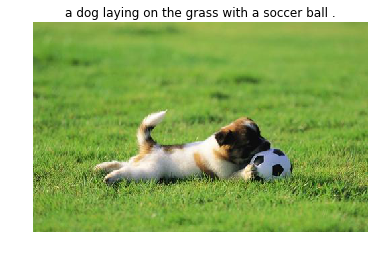

1.jpg Success!
E:\大学相关\大学相关（大四春）\major\workspace\images_q/2.jpg
  0) a white and white cat is sitting in the grass . (p=0.000310)
  1) a white and white cat is sitting in a field (p=0.000297)
  2) a white and white cat is sitting in the grass (p=0.000211)


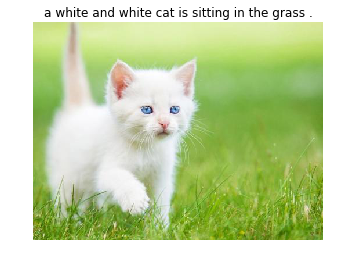

2.jpg Success!
Process Success!


In [5]:
#图片预处理
with tf.Session(graph=g) as sess:
    # 载入训练好的模型
    restore_fn(sess)
    generator = caption_generator.CaptionGenerator(model, vocab)
         
    # 循环文件夹
    for root,dirs,files in os.walk(input_files):
        for file in files:
            # 打印图片路径及名称
            image_path = os.path.join(root,file)
            print(image_path)
            # 载入图片
            image = tf.gfile.FastGFile(os.path.join(root,file), 'rb').read()   
            # 获得图片描述
            captions = generator.beam_search(sess, image)
            # 打印多个标题
            for i, caption in enumerate(captions):
                sentence = [vocab.id_to_word(w) for w in caption.sentence[1:-1]]
                sentence = " ".join(sentence)
                if i == 0:
                    title = sentence
                print("  %d) %s (p=%f)" % (i, sentence, math.exp(caption.logprob)))

            # 显示图片
            img=Image.open(image_path)
            plt.imshow(img)
            plt.title(title)
            plt.axis('off')
            plt.show()
            
            #将图片路径以及内容保存
            tmp_df = pd.DataFrame(data=[[image_path,title]], columns=["Image_Path","Image_Content"])
            df = df.append(tmp_df)#这里一定要再赋值一次
            
            print(file+" Success!")

print("Process Success!")

In [6]:
#查询图片和视频
# 载入模型
embedder = SentenceTransformer('bert-base-nli-mean-tokens')

In [7]:
# 读取视频和图片的文本数据
corpus_images_path = os.path.join(os.path.dirname(os.getcwd()),"images_result.csv")
corpus_videos_path = os.path.join(os.path.dirname(os.getcwd()),"videos_result.csv")
corpus_images_df = pd.read_csv(corpus_images_path, engine='python', encoding = 'utf-8') #注意中文路径报错、注意编码
corpus_videos_df = pd.read_csv(corpus_videos_path, engine='python', encoding = 'utf-8') 

In [8]:
# 数据预处理
corpus_images = corpus_images_df['Image_Content'].tolist()
corpus_videos = corpus_videos_df['Video_Content'].tolist()

corpus_embeddings_i = embedder.encode(corpus_images)
corpus_embeddings_v = embedder.encode(corpus_videos)

In [9]:
# 查询内容转换
paths = df['Image_Path'].values.tolist()
queries = df['Image_Content'].values.tolist()
query_embeddings = embedder.encode(queries)





Query:


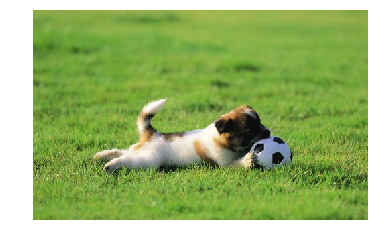


Top 5 most similar images:
a dog laying on the grass with a soccer ball . (Score: 1.0000)
a white and white cat is sitting in the grass . (Score: 0.4656)
a woman standing on a beach holding a surfboard . (Score: 0.2843)




Query:


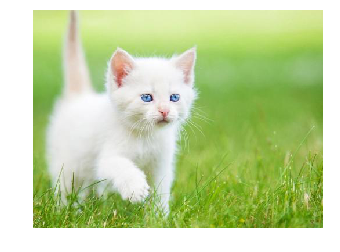


Top 5 most similar images:
a white and white cat is sitting in the grass . (Score: 1.0000)
a dog laying on the grass with a soccer ball . (Score: 0.4656)
a woman standing on a beach holding a surfboard . (Score: 0.1600)




Query:


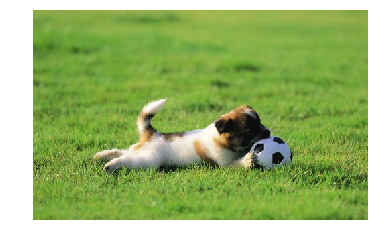


Top 5 most similar videos:
a white dog with a red bow tie sitting on a couch . (Score: 0.4479)
a white plate topped with a piece of cake . (Score: 0.0561)




Query:


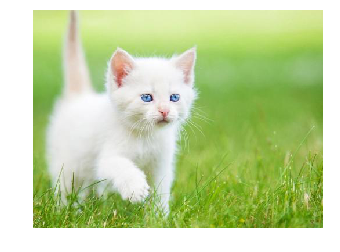


Top 5 most similar videos:
a white dog with a red bow tie sitting on a couch . (Score: 0.5687)
a white plate topped with a piece of cake . (Score: 0.3122)


In [10]:
# 查询

#查询结果显示数量
closest_n = 5

#查询结果变量
res_i = pd.DataFrame(columns = ["i_path","i_content","i_score","q_path"])
res_v = pd.DataFrame(columns = ["v_path","v_content","v_score","q_path"])

#Images
for query, query_embedding, path in zip(queries, query_embeddings, paths):
    #这个函数怀疑有长度限制，字符串超过一定长度会自动生成负数向量
    distances = scipy.spatial.distance.cdist([query_embedding], corpus_embeddings_i, "cosine")[0]

    results_i = zip(range(len(distances)), distances)
    results_i = sorted(results_i, key=lambda x: x[1])

    print("\n\n======================\n\n")
    print("Query:")
    im = mpimg.imread(path) 
    plt.imshow(im) # 显示图片
    plt.axis('off') # 不显示坐标轴
    plt.show()
    print("\nTop 5 most similar images:")

    for idx, distance in results_i[0:closest_n]:
        for index,row in corpus_images_df.iterrows():
            if row["Image_Content"] == corpus_images[idx].strip():
                tmp_df = pd.DataFrame(data=[[row["Image_Path"],row["Image_Content"],1-distance,path]], columns=["i_path","i_content","i_score","q_path"])
                res_i = res_i.append(tmp_df)
                break
        print(corpus_images[idx].strip(), "(Score: %.4f)" % (1-distance))

#Videos
for query, query_embedding, path in zip(queries, query_embeddings, paths):
    distances = scipy.spatial.distance.cdist([query_embedding], corpus_embeddings_v, "cosine")[0]

    results_v = zip(range(len(distances)), distances)
    results_v = sorted(results_v, key=lambda x: x[1])

    print("\n\n======================\n\n")
    print("Query:")
    im = mpimg.imread(path) 
    plt.imshow(im) # 显示图片
    plt.axis('off') # 不显示坐标轴
    plt.show()
    print("\nTop 5 most similar videos:")

    for idx, distance in results_v[0:closest_n]:
        for index,row in corpus_videos_df.iterrows():
            if row["Video_Content"] == corpus_videos[idx].strip():
                tmp_df = pd.DataFrame(data=[[row["Video_Path"],row["Video_Content"],1-distance,path]], columns=["v_path","v_content","v_score","q_path"])
                res_v = res_v.append(tmp_df)
                break
        print(corpus_videos[idx].strip(), "(Score: %.4f)" % (1-distance))


检索内容：


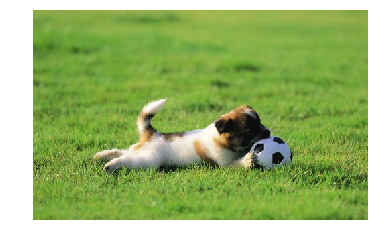


Top 5 most similar images:
1.0


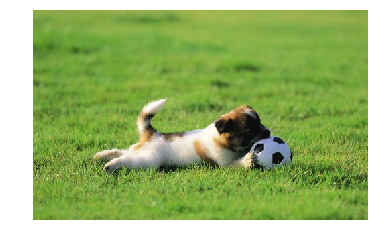

0.4655757475242164


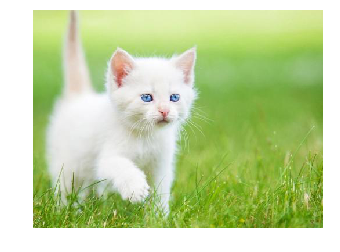

0.2843159911650933


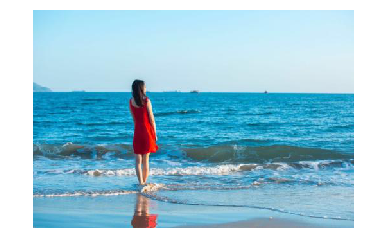


检索内容：


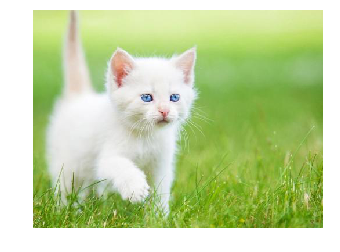


Top 5 most similar images:
0.9999999999999998


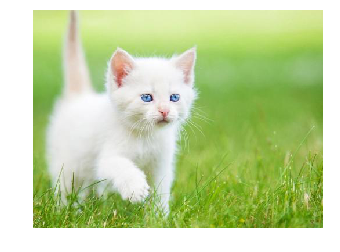

0.4655757475242164


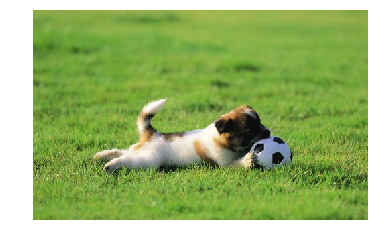

0.15997841081337139


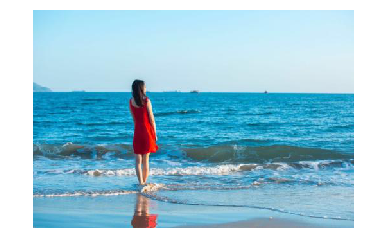

In [11]:
#展示图片
res_i.reset_index(drop=True, inplace=True)

q_init = res_i["q_path"][0]
print("\n检索内容：")
im = mpimg.imread(q_init) 
plt.imshow(im) # 显示图片
plt.axis('off') # 不显示坐标轴
plt.show()
print("\nTop 5 most similar images:")
counti = 0

for index,row in res_i.iterrows():
    if row["q_path"] != q_init:
        q_init = row["q_path"]
        print("\n检索内容：")
        im = mpimg.imread(q_init) 
        plt.imshow(im) # 显示图片
        plt.axis('off') # 不显示坐标轴
        plt.show()
        print("\nTop 5 most similar images:")
        counti = 0
    
    counti = counti + 1
    if counti > closest_n:
        continue
    
    print(row["i_score"])
    im = mpimg.imread(row["i_path"]) 
    plt.imshow(im) # 显示图片
    plt.axis('off') # 不显示坐标轴
    plt.show()



检索内容：


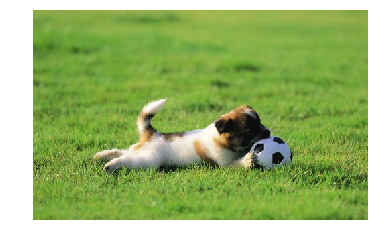


Top 5 most similar videos:
0.447889900052415
E:\大学相关\大学相关（大四春）\major\workspace\videos/1.mp4
0.05612151499908746
E:\大学相关\大学相关（大四春）\major\workspace\videos/2.mp4

检索内容：


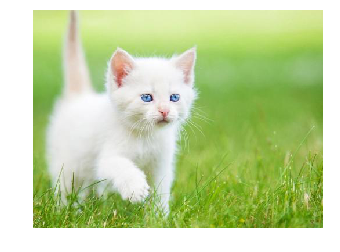


Top 5 most similar videos:
0.5687400366787954
E:\大学相关\大学相关（大四春）\major\workspace\videos/1.mp4
0.3121957875738469
E:\大学相关\大学相关（大四春）\major\workspace\videos/2.mp4
Finish show


In [13]:
#展示视频
res_v.reset_index(drop=True, inplace=True)

q_init = res_i["q_path"][0]
print("\n检索内容：")
im = mpimg.imread(q_init) 
plt.imshow(im) # 显示图片
plt.axis('off') # 不显示坐标轴
plt.show()
print("\nTop 5 most similar videos:")
countv = 0

for index,row in res_v.iterrows():
    
    if row["q_path"] != q_init:
        q_init = row["q_path"]
        print("\n检索内容：")
        im = mpimg.imread(q_init) 
        plt.imshow(im) # 显示图片
        plt.axis('off') # 不显示坐标轴
        plt.show()
        print("\nTop 5 most similar videos:")
        countv = 0
    
    countv = countv + 1
    if countv > closest_n:
        continue
    
    print(row["v_score"])
    print(row["v_path"])
    
    cap = cv.VideoCapture(row["v_path"])
    FPS = cap.get(cv.CAP_PROP_FPS)
    delay = int(1000/FPS)
    while cap.isOpened():
        ret, frame = cap.read()
        # if frame is read correctly ret is True
        if not ret:
            print("Can't receive frame (stream end?). Exiting ...")
            break
        #blur = cv.GaussianBlur(frame, (0, 0), 5)
        cv.imshow('frame', frame)
        #cv.imshow('blur', blur)
        # press q to exit
        if cv.waitKey(delay) == ord('q'):
            break
    cap.release()
    cv.destroyAllWindows()

print("Finish show")

In [14]:
res_i

,i_path,i_content,i_score,q_path
0,E:\大学相关\大学相关（大四春）\major\workspace\images/1.jpg,a dog laying on the grass with a soccer ball .,1.000000,E:\大学相关\大学相关（大四春）\major\workspace\images_q/1.jpg
1,E:\大学相关\大学相关（大四春）\major\workspace\images/2.jpg,a white and white cat is sitting in the grass .,0.465576,E:\大学相关\大学相关（大四春）\major\workspace\images_q/1.jpg
2,E:\大学相关\大学相关（大四春）\major\workspace\images/3.jpg,a woman standing on a beach holding a surfboard .,0.284316,E:\大学相关\大学相关（大四春）\major\workspace\images_q/1.jpg
3,E:\大学相关\大学相关（大四春）\major\workspace\images/2.jpg,a white and white cat is sitting in the grass .,1.000000,E:\大学相关\大学相关（大四春）\major\workspace\images_q/2.jpg
4,E:\大学相关\大学相关（大四春）\major\workspace\images/1.jpg,a dog laying on the grass with a soccer ball .,0.465576,E:\大学相关\大学相关（大四春）\major\workspace\images_q/2.jpg
5,E:\大学相关\大学相关（大四春）\major\workspace\images/3.jpg,a woman standing on a beach holding a surfboard .,0.159978,E:\大学相关\大学相关（大四春）\major\workspace\images_q/2.jpg


In [15]:
res_v

,v_path,v_content,v_score,q_path
0,E:\大学相关\大学相关（大四春）\major\workspace\videos/1.mp4,a white dog with a red bow tie sitting on a co...,0.447890,E:\大学相关\大学相关（大四春）\major\workspace\images_q/1.jpg
1,E:\大学相关\大学相关（大四春）\major\workspace\videos/2.mp4,a white plate topped with a piece of cake .,0.056122,E:\大学相关\大学相关（大四春）\major\workspace\images_q/1.jpg
2,E:\大学相关\大学相关（大四春）\major\workspace\videos/1.mp4,a white dog with a red bow tie sitting on a co...,0.568740,E:\大学相关\大学相关（大四春）\major\workspace\images_q/2.jpg
3,E:\大学相关\大学相关（大四春）\major\workspace\videos/2.mp4,a white plate topped with a piece of cake .,0.312196,E:\大学相关\大学相关（大四春）\major\workspace\images_q/2.jpg


In [16]:
# 查询文本
# 文本路径
input_files_T = os.path.join(os.path.dirname(os.getcwd()),"textures/")
# 储存查询结果
results_t=[]

In [17]:
# 读取停用词
cacheStopWords=pw.words("english")

In [18]:
# 查询内容转换
paths = df['Image_Path'].values.tolist()
queries = df['Image_Content'].values.tolist()
tokenized_queries = []

for query in queries:
    query=''.join([word+" " for word in query.split() if word not in cacheStopWords])
    tokenized_queries.append(query.split(" "))


In [19]:
# 查询

#查询结果显示数量
closest_n = 5

for tokenized_query, q_path in zip(tokenized_queries, paths):
    # 储存文本路径
    texture_path = [] 
    # 储存文本相似度
    texture_score = []
    #储存问题路径
    texture_qpath = []
    corpus = []
    # 循环文件夹
    for root,dirs,files in os.walk(input_files_T):
        for file in files:
            # 获取路径
            text_path = os.path.join(root,file)
            #print(text_path)
        
            with open(text_path, "r", encoding='utf-8') as f:  # 打开文件
                tmp_content = f.read()  # 读取文件
        
            corpus.append(tmp_content) # 注意是list
            
            texture_path.append(text_path)
            texture_qpath.append(q_path)
            
    tokenized_corpus = [doc.split(" ") for doc in corpus]
    bm25 = BM25Plus(tokenized_corpus)
    doc_score = bm25.get_scores(tokenized_query)
       
    #将结果保存
    texture_score.extend(doc_score)
           
    results_t_tmp = zip(texture_path, texture_score, texture_qpath)
    results_t_tmp = sorted(results_t_tmp, key=lambda x: x[1], reverse = True)#这里是降序
    
    results_t.extend(results_t_tmp)



检索内容：


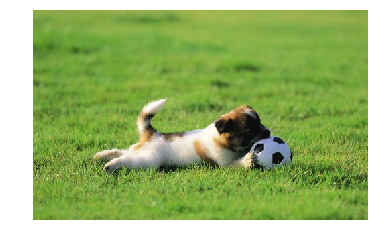


Top 5 most similar images:
E:\大学相关\大学相关（大四春）\major\workspace\textures/C1.txt 3.8769622233431233
E:\大学相关\大学相关（大四春）\major\workspace\textures/C2.txt 3.6723399831679657
E:\大学相关\大学相关（大四春）\major\workspace\textures/C3.txt 3.3681832512540213

检索内容：


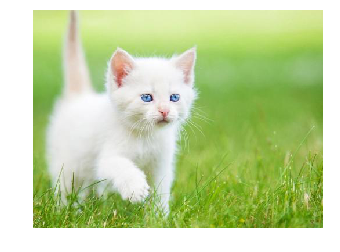


Top 5 most similar images:
E:\大学相关\大学相关（大四春）\major\workspace\textures/C1.txt 3.686524029051288
E:\大学相关\大学相关（大四春）\major\workspace\textures/C2.txt 3.6723399831679657
E:\大学相关\大学相关（大四春）\major\workspace\textures/C3.txt 3.3681832512540213


In [21]:
# 展示文本
q_init = results_t[0][2]
print("\n检索内容：")
im = mpimg.imread(q_init) 
plt.imshow(im) # 显示图片
plt.axis('off') # 不显示坐标轴
plt.show()
print("\nTop 5 most similar images:")
countt = 0


for row in results_t:
    if row[2] != q_init:
        q_init = row[2]
        print("\n检索内容：")
        im = mpimg.imread(q_init) 
        plt.imshow(im) # 显示图片
        plt.axis('off') # 不显示坐标轴
        plt.show()
        print("\nTop 5 most similar images:")
        countt = 0
    
    countt = countt + 1
    if countt > closest_n:
        continue
    print(row[0], row[1])

In [22]:
results_t

[('E:\\大学相关\\大学相关（大四春）\\major\\workspace\\textures/C1.txt',
  3.8769622233431233,
  'E:\\大学相关\\大学相关（大四春）\\major\\workspace\\images_q/1.jpg'),
 ('E:\\大学相关\\大学相关（大四春）\\major\\workspace\\textures/C2.txt',
  3.6723399831679657,
  'E:\\大学相关\\大学相关（大四春）\\major\\workspace\\images_q/1.jpg'),
 ('E:\\大学相关\\大学相关（大四春）\\major\\workspace\\textures/C3.txt',
  3.3681832512540213,
  'E:\\大学相关\\大学相关（大四春）\\major\\workspace\\images_q/1.jpg'),
 ('E:\\大学相关\\大学相关（大四春）\\major\\workspace\\textures/C1.txt',
  3.686524029051288,
  'E:\\大学相关\\大学相关（大四春）\\major\\workspace\\images_q/2.jpg'),
 ('E:\\大学相关\\大学相关（大四春）\\major\\workspace\\textures/C2.txt',
  3.6723399831679657,
  'E:\\大学相关\\大学相关（大四春）\\major\\workspace\\images_q/2.jpg'),
 ('E:\\大学相关\\大学相关（大四春）\\major\\workspace\\textures/C3.txt',
  3.3681832512540213,
  'E:\\大学相关\\大学相关（大四春）\\major\\workspace\\images_q/2.jpg')]